# Project 7
by Jan Bauer, (#18-764-571)  
together with Adrian Iten, (#15-722-291)  

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(threshold=np.inf)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Constants

In [3]:
# All these values given in the project description
sigma = 1
variance = sigma**2
Q_1m = 200.8969
Q_1h = 3.6289

## Functions

Considering a random data matrix $X \in R^{t x N}$ where $X_{ij}$~$N(0, \sigma^2)$ iid for all i, j.  
The covariance matrix $Y_t = \frac{1}{t} XX^T$, having eigenvalues $\lambda_1, ..., \lambda_N$.  
These eigenvalues can be then considered to be random variables themselves.  
The eigenvalues should then follow a Marčenko-Pastur (MP) distribution with parameter Q.  
$p(\lambda) = \frac{Q}{2 \pi \sigma^2}*\frac{\sqrt{(\lambda_{max} - \lambda)(\lambda - \lambda_{min})}}{\lambda}$  
$\lambda_{min}= \sigma^2(1 - \sqrt{\frac{1}{Q}})^{2} = \sigma^2(1 + \frac{1}{Q}-2\sqrt{\frac{1}{Q}})$  
$\lambda_{max}= \sigma^2(1 + \sqrt{\frac{1}{Q}})^{2} = \sigma^2(1 + \frac{1}{Q}+2\sqrt{\frac{1}{Q}})$  
The following function implements the marchenko pastur probability density function.

In [4]:
def marchenko_pastur_pdf(var, Q, n_samples):
    """
    This function returns the probability density function
    of a Marchenko-Pastur distribution 
    Args:
        var (float): Variance
        Q (float): T/N where T is the number of rows and N the number of columns
        n_samples (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
            
    l_min = var * (1 + 1./Q - 2*((1. / Q) ** (1/2)))
    l_max = var * (1 + 1./Q + 2*((1. / Q) ** (1/2)))
    print("l_min = {}; l_max = {}".format(l_min, l_max))
    lambdas = np.linspace(l_min, l_max, n_samples)
    pdf = Q / (2*np.pi * var * lambdas)*((l_max - lambdas)*(lambdas - l_min)) ** .5
    pdf = pd.Series(pdf, index=lambdas)
    return l_min, l_max, pdf

In [5]:
def plot_eigenvalue_distribution(eigenvalues, bins, pdf):
    #plt.plot(lambdas, results_1m, color="r")
    plt.plot(pdf, label="Fitted Marčenko-Pastur PDF", color="orange")
    plt.hist(eigenvalues, bins=bins, density=True, label="Observed Eigenvalue Dist.", color="blue")
    plt.title("Distribution of eigenvalues")
    plt.legend()
    plt.show()

All $\lambda$'s smaller than $\lambda_{max}$ are replaced by a constant (in our case $\frac{(\lambda_{min} + \lambda_{max})}{2}$) since they are considered to be noise.

In [6]:
def threshold_filter(values, threshold, constant):
    filtered_values = np.array([value if value >= threshold else constant for value in values])
    return filtered_values 

In [7]:
assert (threshold_filter([1,2,3], 1.5, 1.0) == np.array([1, 2, 3])).any()
assert (threshold_filter([1,2,3,4,5,6,7,8,9,10], 4.9, 1.0) == np.array([1.0, 1.0, 1.0, 1.0, 5, 6, 7, 8, 9, 10.0])).any()

Renormalize the eigenvalues such that $\sum_{i=1}^N \lambda_i = N$ holds for the filtered eigenvalues.

In [8]:
def renormalize(arr):
    return (len(arr)/sum(arr))*arr

In [9]:
assert (renormalize(np.array([3])) == np.array([1])).all()
assert (renormalize(np.array([1,2])) == np.array([2/3, 4/3])).all()
assert (renormalize(np.array([1,2,3])) == np.array([0.5, 1. , 1.5])).all()

Filtering the eigenvalues includes replacing all eigenvalues smaller than $\lambda_{max}$ with a constant and then renormalizing them.

In [10]:
def filter_eigenvalues(eigenvalues, threshold, constant):
    return renormalize(threshold_filter(eigenvalues, threshold, constant))

Undo the diagonalisation in order to get the denoised correlation matrix
$\bar{Y} = V \Lambda V^{-1}$  
where V is the eigenvectors matrix and $\Lambda$ is the diagonal matrix of eigenvalues.

In [11]:
def denoise_matrix(eigenvectors, filtered_eigenvalues):
    denoised_matrix = eigenvectors.dot(np.diag(filtered_eigenvalues)).dot(np.linalg.inv(eigenvectors))
    return denoised_matrix

The denoised matrix $\bar{Y}$ where potentially $\bar{Y}_{ii}$ ≠ 1, can be normalized to have unit diagonal.  
This can be done by computing $\tilde{Y} = D\bar{Y}D$ with $D = \frac{1}{\sqrt{\bar{Y}_{ii}}}$

In [12]:
def normalize(e):
    return 1.0/np.sqrt(e)
normalize_vector = np.vectorize(normalize)

def normalize_matrix(matrix):
    diag = np.diagonal(matrix)
    normalized_diag = normalize_vector(diag)
    D = np.diag(normalized_diag)
    normalized_matrix = D.dot(matrix).dot(D)
    return normalized_matrix

## Load the correlation matrix

In [13]:
cor_mat_1m = np.load('/content/drive/My Drive/network_science_datasets/ex7/cormat_1m.npy')
cor_mat_1h = np.load('/content/drive/My Drive/network_science_datasets/ex7/cormat_1h.npy')

In [14]:
print(np.mean(cor_mat_1m)) # Check the mean of the matrix elements
print(np.var(cor_mat_1m)) # Check the variance of the individual matrix entries
# => The entries do not have mean zero and variance one

0.3027156198861751
0.01242405487734957


In [15]:
print(np.mean(cor_mat_1h)) # Check the mean of the matrix elements
print(np.var(cor_mat_1h)) # Check the variance of the individual matrix entries
# => The entries do not have mean zero and variance one

0.30288133041749427
0.024906831315257408


In [16]:
eigval_1m, eigvec_1m = np.linalg.eig(cor_mat_1m)
eigval_1h, eigvec_1h = np.linalg.eig(cor_mat_1h)

In [17]:
n_samples = 100

In [18]:
#upper eigenvalue threshold
uet = 5 
lambdas = np.linspace(0.1, uet, num=n_samples)

l_min = 0.8638723608405807; l_max = 1.146082994368982


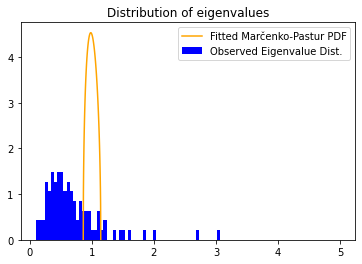

In [19]:
l_min_1m, l_max_1m, mp_pdf_1m = marchenko_pastur_pdf(sigma**2, Q_1m, n_samples)
l_mean_1m = (l_min_1m + l_max_1m)/2
plot_eigenvalue_distribution(eigval_1m, lambdas, mp_pdf_1m)

l_min = 0.22567875041002616; l_max = 2.3254524463713677


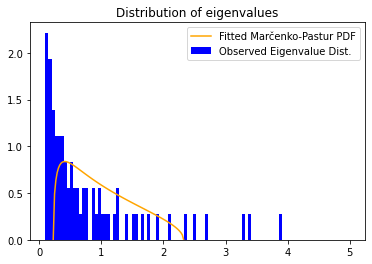

In [20]:
l_min_1h, l_max_1h, mp_pdf_1h = marchenko_pastur_pdf(sigma**2, Q_1h, n_samples)
l_mean_1h = (l_min_1h + l_max_1h)/2
plot_eigenvalue_distribution(eigval_1h, lambdas, mp_pdf_1h)

In [21]:
# The mean value between lambda_min and lambda_max is used to replace all eigenvalues < lambda_max.
filtered_eigenvalues_1m = filter_eigenvalues(eigval_1m, l_max_1m, l_mean_1m)
denoised_correlation_matrix_1m = denoise_matrix(eigvec_1m, filtered_eigenvalues_1m)
normalized_correlation_matrix_1m = normalize_matrix(denoised_correlation_matrix_1m)
# Make sure the diagonal does not contain any values slightly bigger than 1 like 1.0000000002 for example
# This was proposed by the TA (Yu Gao)
np.fill_diagonal(normalized_correlation_matrix_1m, 1) 

In [22]:
# Non denoised eigenvalues
print(eigval_1m)

[30.15967999  3.06441856  2.69300287  2.01853023  1.87088218  1.61804659
  1.5286698   1.44483891  1.3705737   1.21522435  1.20763077  1.18148502
  1.13456249  1.12095821  1.09757579  1.04829675  1.02094271  0.07619294
  0.11351842  0.99073481  0.95252709  0.94956666  0.13593653  0.92901798
  0.9060765   0.89551127  0.17642145  0.18275983  0.87128445  0.85969399
  0.84981126  0.22164492  0.24641848  0.8242317   0.79908457  0.805316
  0.81074884  0.77242311  0.25038788  0.7496294   0.26942891  0.73472574
  0.72888706  0.69964766  0.70444103  0.27694144  0.28200079  0.29220966
  0.29358174  0.30151474  0.68103054  0.67564233  0.3163477   0.32930381
  0.66727062  0.65497874  0.64891423  0.3384005   0.34501027  0.6430286
  0.35174528  0.35579498  0.63541305  0.63714127  0.62493966  0.3615253
  0.61306728  0.5971473   0.36626357  0.37664014  0.38565092  0.5802699
  0.39680543  0.57634413  0.55863149  0.55703092  0.54810024  0.42448627
  0.41284013  0.40708333  0.43184792  0.53750456  0.4734

In [23]:
# Denoised eigenvalues
n_eigval_1m, n_eigvec_1m = np.linalg.eig(normalized_correlation_matrix_1m)
print(n_eigval_1m)

[21.40040488  2.09878282  1.91678656  1.44433362  1.35250536  1.17234094
  1.13615256  1.06743758  1.01772054  0.93886403  0.90701152  0.89399481
  0.8736963   0.62077361  0.62462698  0.63859583  0.63916958  0.64433923
  0.81462794  0.80856095  0.80585843  0.64800397  0.6581221   0.6600181
  0.66005369  0.66448629  0.66251961  0.79422946  0.66649611  0.66798048
  0.79295608  0.66895572  0.78943759  0.78450337  0.67458502  0.67539716
  0.6760735   0.67717377  0.67920814  0.67974885  0.68406118  0.78299735
  0.68695979  0.78011043  0.77842173  0.68930804  0.69256231  0.69417597
  0.77515118  0.69980745  0.70070602  0.70291845  0.70423428  0.77134654
  0.7706351   0.76898668  0.76782724  0.70686225  0.76763331  0.70786015
  0.71024484  0.71061809  0.76403883  0.76363762  0.76251338  0.76243131
  0.76076273  0.7146188   0.71764235  0.7247887   0.72287682  0.71920243
  0.72744948  0.76006246  0.75809488  0.72067646  0.71549344  0.72967135
  0.73258054  0.73403775  0.75613828  0.71587323  0.

In [24]:
# The mean value between lambda_min and lambda_max is used to replace all eigenvalues < lambda_max.
filtered_eigenvalues_1h = filter_eigenvalues(eigval_1h, l_max_1h, l_mean_1h)
denoised_correlation_matrix_1h = denoise_matrix(eigvec_1h, filtered_eigenvalues_1h)
normalized_correlation_matrix_1h = normalize_matrix(denoised_correlation_matrix_1h)
# Make sure the diagonal does not contain any values slightly bigger than 1 like 1.0000000002 for example
# This was proposed by the TA (Yu Gao)
np.fill_diagonal(normalized_correlation_matrix_1h, 1) 

In [25]:
# Non denoised eigenvalues
print(eigval_1h)

[3.10278357e+01 6.11462818e+00 3.90762710e+00 3.38341207e+00
 3.29244496e+00 2.72151599e+00 2.48442167e+00 2.33355883e+00
 2.08467102e+00 1.90042517e+00 1.78149180e+00 1.67893845e+00
 1.54920798e+00 1.51315768e+00 1.39114035e+00 1.28089150e+00
 1.26239606e+00 1.18971931e+00 1.12630673e+00 1.08744639e+00
 1.03529794e+00 9.58606917e-01 9.89977946e-01 9.15589513e-01
 8.68960156e-01 8.50254263e-01 7.92407534e-01 7.71291141e-01
 7.36828468e-01 7.05923023e-01 6.74072270e-01 6.32130296e-01
 6.05902486e-01 5.72376717e-01 5.61119174e-01 5.22957580e-01
 5.16337739e-01 4.97981478e-01 4.79414479e-01 4.56641482e-01
 4.40709127e-01 4.29785965e-01 4.15268348e-01 3.88825844e-01
 3.75706258e-01 3.70619833e-01 3.59691965e-01 3.45398785e-01
 3.29092969e-01 3.18825500e-01 3.02578385e-01 2.81592137e-01
 2.63001216e-01 2.56798749e-01 2.54752222e-01 2.47836340e-01
 2.35173856e-01 2.26782708e-01 1.58493466e-02 1.96892329e-02
 2.10099146e-01 2.03854554e-01 2.57622802e-02 2.91972826e-02
 1.94749478e-01 1.885487

In [26]:
# Denoised eigenvalues
n_eigval_1h, n_eigvec_1h = np.linalg.eig(normalized_correlation_matrix_1h)
print(n_eigval_1h)

[17.47141546  3.36605964  2.25662639  1.96133633  1.9208831   1.60052564
  1.46578681  1.37939995  0.88805578  0.86808227  0.86073032  0.83886415
  0.82635314  0.82317752  0.64734959  0.80902995  0.80739343  0.80363027
  0.65072197  0.65186048  0.65421276  0.65738291  0.65770403  0.66225051
  0.80142705  0.80031826  0.66348441  0.79739907  0.66580984  0.79622166
  0.66886958  0.66630577  0.79442622  0.79289626  0.67134104  0.67161008
  0.67522197  0.67652103  0.78994508  0.78647096  0.67839774  0.68164626
  0.6797524   0.68253527  0.78333831  0.68718719  0.68868126  0.68580221
  0.69131909  0.78046817  0.77923214  0.69438353  0.69610881  0.69732526
  0.70027911  0.77613922  0.70710335  0.77352556  0.77173992  0.77118768
  0.70908148  0.7680815   0.7104472   0.76755074  0.76488172  0.76135231
  0.71230734  0.71756171  0.71474114  0.71639097  0.71310271  0.72122139
  0.75927025  0.75850916  0.72498471  0.72626997  0.72835455  0.75708494
  0.7304806   0.75660318  0.74427198  0.74582307  0

## A07.2 - Correlation MSTs
1. Make a scatterplot of the 1 hour vs 1 minute denoised correlations (1 data point per pair of stocks)

In [27]:
ncm_1m_flattened = normalized_correlation_matrix_1m.flatten()
ncm_1h_flattened = normalized_correlation_matrix_1h.flatten()

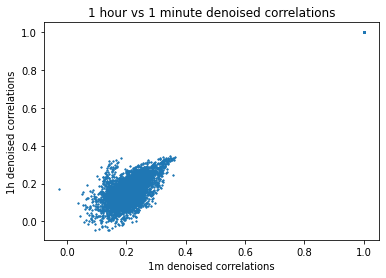

In [28]:
plt.scatter(ncm_1m_flattened, ncm_1h_flattened, s=1);
plt.xlabel("1m denoised correlations");
plt.ylabel("1h denoised correlations");
plt.title("1 hour vs 1 minute denoised correlations");
plt.show();

2. From the denoised correlation matrices, build the Minimum Spanning Tree.

In [29]:
with open('/content/drive/My Drive/network_science_datasets/ex7/stocknames.txt') as f:
    stocknames = [line.strip() for line in f.readlines()]

In [30]:
stocks = {i: stocknames[i] for i in range(0, 97)}

In [31]:
def compute_distance(element):
    #if element > 1:
    #    element = 1
    distance = np.sqrt(2*(1-element))
    return distance

In [32]:
def build_mst(denoised_cormat, names):
    n = 97
    
    mst = nx.complete_graph(n=n)
    mst.add_nodes_from([i for i in range(0, n)])
    
    weights = np.vectorize(compute_distance)(denoised_cormat)
    for i, o in mst.edges():
        mst[i][o]['weight'] = weights[i][o]
    
    mst = nx.minimum_spanning_tree(mst)
    
    nx.set_node_attributes(mst, names, 'name')
    
    return mst

In [33]:
compute_distances = np.vectorize(compute_distance)

In [34]:
distance_matrix_1m = compute_distances(normalized_correlation_matrix_1m);
distance_matrix_1h = compute_distances(normalized_correlation_matrix_1h);

In [35]:
G_1m = nx.from_numpy_matrix(distance_matrix_1m)
MST_1m = nx.minimum_spanning_tree(G_1m)

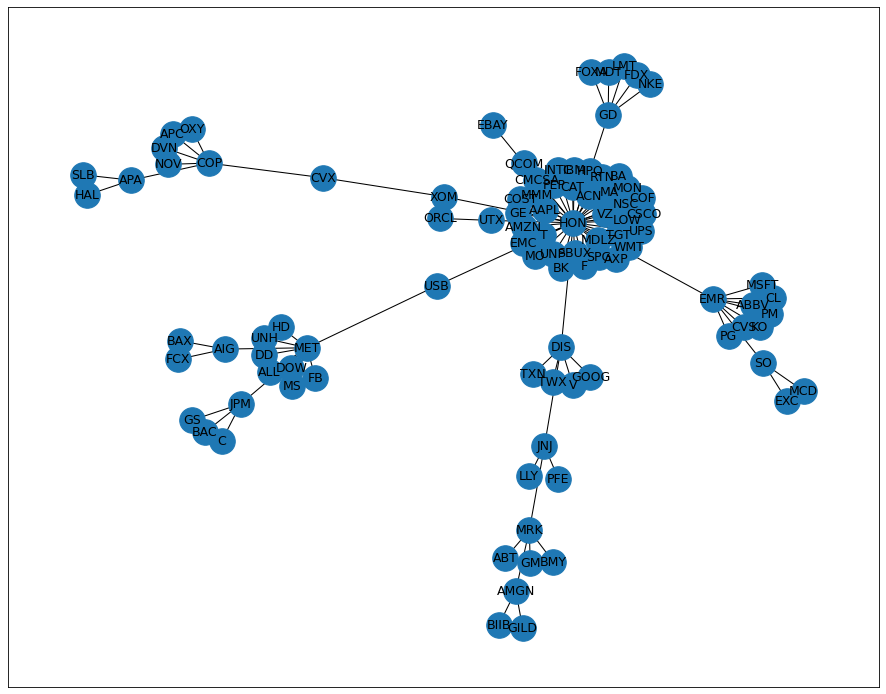

In [36]:
plt.figure(figsize=(15,12), dpi=75)
nx.draw_networkx(MST_1m, labels=stocks, node_size=600)

In [37]:
G_1h = nx.from_numpy_matrix(distance_matrix_1h)
MST_1h = nx.minimum_spanning_tree(G_1h)

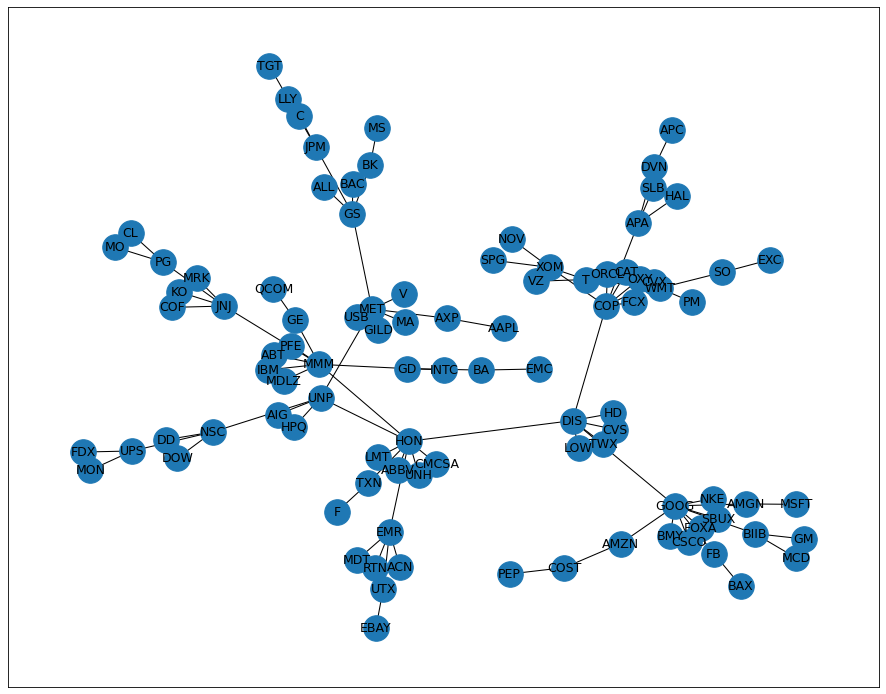

In [38]:
plt.figure(figsize=(15,12), dpi=75)
nx.draw_networkx(MST_1h, labels=stocks, node_size=600)

3. assign the correct ticker (’AAPL’, ’AMZN’, ...) as an attribute to the nodes and calculate the degrees

In [39]:
degrees_1m = [MST_1m.degree[n] for n in MST_1m.nodes()]
degrees_1h = [MST_1h.degree[n] for n in MST_1h.nodes()]

4. make a scatterplot of the 1 hour vs 1 minute MST degrees of stocks (1 data point per stock)

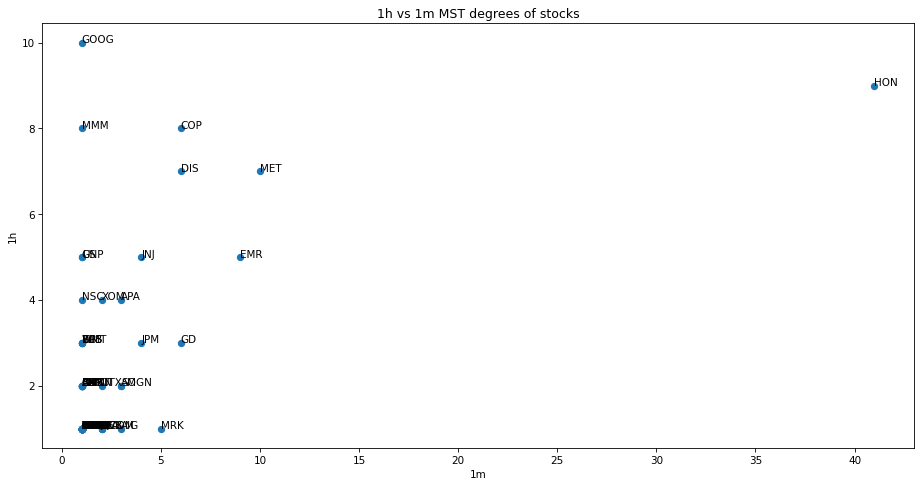

In [40]:
plt.figure(figsize=(15,7.5), dpi=75)
plt.title('1h vs 1m MST degrees of stocks')
plt.xlabel('1m')
plt.ylabel('1h')
plt.scatter(degrees_1m, degrees_1h)
for i in range(97):
    plt.annotate(stocknames[i], (degrees_1m[i], degrees_1h[i]))
plt.show()

## A07.3 - Conclusions

### 1. Is there a ‘market mode’?
There is a ticket with a really high eingenvalue both in the minute as well as hourly ticker: AAPL. It is significantly larger than expected as visible in below code. This also is the case in the denoised as well as non-denoised correlation matrix, the value is just higher in the non-denoised correlation matrix.

In [66]:
print(stocknames[np.abs(n_eigval_1m).argmax()])
print(np.abs(n_eigval_1m).max())
print(stocknames[np.abs(n_eigval_1h).argmax()])
print(np.abs(n_eigval_1h).max())
print(np.sort(n_eigval_1h)[::-1][:5])
print(np.sort(n_eigval_1m)[::-1][:5])
market_mode_index = np.abs(n_eigval_1m).argmax()
print(market_mode_index, market_mode_index == np.abs(n_eigval_1h).argmax())

AAPL
21.40040488283305
AAPL
17.471415464800128
[17.47141546  3.36605964  2.25662639  1.96133633  1.9208831 ]
[21.40040488  2.09878282  1.91678656  1.44433362  1.35250536]
0 True


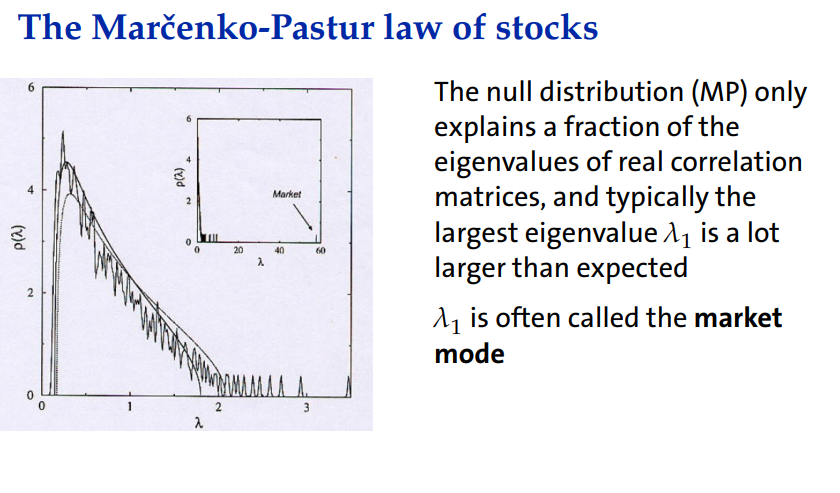


### 2. Which is the stock that has the strongest relation with the market?
According to the exercise: a stock’s relation to the market mode is given by the
corresponding element of the ***absolute*** eigenvector of the largest
eigenvalue. Therefore the following are the stocks with the strongest relation with the market:

DD in 1m Ticker

C in 1h Ticker

It is important that we consider the **denoised** correlation matrix.

In [63]:
print("------1m Ticker-------")
print(stocknames[np.abs(n_eigvec_1m[market_mode_index,:]).argmax()])
print("Non-denoised (ignore):", stocknames[np.abs(eigvec_1m[market_mode_index,:]).argmax()])
print("------1h Ticker-------")
print(stocknames[np.abs(n_eigvec_1h[market_mode_index,:]).argmax()])
print("Non-denoised (ignore):", stocknames[np.abs(eigvec_1h[market_mode_index,:]).argmax()])

------1m Ticker-------
DD
Non-denoised (ignore): AXP
------1h Ticker-------
C
Non-denoised (ignore): COST


### 3. Which are the 5 stocks with highest degree on the MST?
The top 5 stocks with the highest degree in the 1minute MST are: HON, MET, EMR, COP, DIS (descending order)

In the 1h MST the top 5 stocks with highest degree are: GOOG, HON, COP, MMM, DIS (descending)

This is visible from below code snippet and corresponds with the MST network plot in exercise 07.2.

In [ ]:
m_desc = sorted(MST_1m.degree, key=lambda x: x[1], reverse=True)[:5]
h_desc = sorted(MST_1h.degree, key=lambda x: x[1], reverse=True)[:5]
print("-----------1m-----------")
print("\n".join([f'{stocknames[nd[0]]}: Degree {nd[1]}' for nd in m_desc]))
print("-----------1h-----------")
print("\n".join([f'{stocknames[nd[0]]}: Degree {nd[1]}' for nd in h_desc]))


-----------1m-----------
HON: Degree 41
MET: Degree 10
EMR: Degree 9
COP: Degree 6
DIS: Degree 6
-----------1h-----------
GOOG: Degree 10
HON: Degree 9
COP: Degree 8
MMM: Degree 8
DIS: Degree 7


### 4. Is the degree distribution of MSTs qualitatively the same at 1 minute and 1 hour?
The degree distribution of the MSTs is qualitatively the same despite the max degree differing significantly. Both graphs show a big number of nodes having a degree of 1 and only some nodes having a higher degree. The scale is just a bit wider/higher in the 1m case.

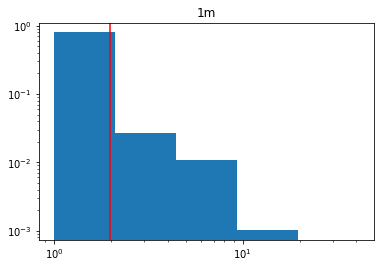

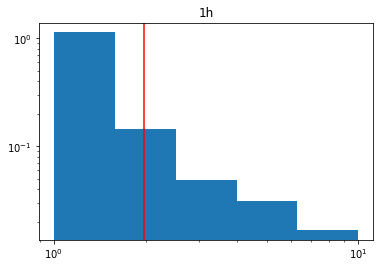

In [ ]:
def average_degree(gr):
  degrs = [x[1] for x in list(gr.degree())]
  return sum(degrs) / len(degrs)

def max_degree(gr):
  if len(list(gr.degree())) == 0:
    raise ValueError("Graph is empty!")
  max_node, curr_max = None, -1
  for node, deg in gr.degree():
    if deg > curr_max:
      max_node, curr_max = node, deg
  return max_node, curr_max

def plot_degree_dist(gr, x_log=False, y_log=False, title=None, n_bins=30):
    max_deg = max_degree(gr)[1]
    degrees = [gr.degree(n) for n in gr.nodes()]
    plt.axvline(x=average_degree(gr), color="red")
    if x_log:
       plt.xscale('log')
       my_bins = np.logspace(np.log10(min(degrees)),np.log10(max(degrees)), n_bins + 1)
    else: 
       my_bins = np.linspace(0, max_deg + 1, n_bins)
    plt.hist(degrees if x_log else degrees, bins=my_bins, density=True, log=y_log)
    plt.title(title)
    plt.show()
  
plot_degree_dist(MST_1m, title="1m", x_log=True, y_log=True, n_bins=5)
plot_degree_dist(MST_1h, title="1h", x_log=True, y_log=True, n_bins=5)